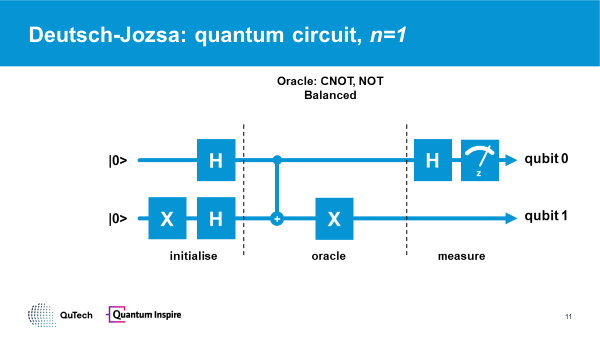

In [ ]:
from openql import openql as ql
import qxelarator
import os
import matplotlib.pyplot as plt

# One function qubit and one ancillary qubit
nqubits = 2

def dj_compile(oracle_spec):
    # make sure the compiler is reinitialised before we set a new algorithm
    ql.initialize()
    ql.set_option('output_dir', 'output')
    ql.set_option('log_level', 'LOG_INFO')

    platform = ql.Platform('myPlatform', 'none')
    dj = ql.Program('deutsch_jozsa', platform, nqubits)

    # The 'magic' part:
    dj.get_compiler().set_option('initialqasmwriter.cqasm_version', '1.0')
    dj.get_compiler().set_option('initialqasmwriter.with_metadata', 'no')
    dj.get_compiler().set_option('scheduledqasmwriter.cqasm_version', '1.0')
    dj.get_compiler().set_option('scheduledqasmwriter.with_metadata', 'no')
    
    initialise  = ql.Kernel('initialise', platform, nqubits)
    oracle      = ql.Kernel('oracle', platform, nqubits)
    measurement = ql.Kernel('maesurement', platform, nqubits)

    for q in range(nqubits):
        initialise.prepz(q)

    # A different way to define the quantum circuit: <kernel name>.<quantum gate name>(<qubits>)
    initialise.x(1)
    initialise.hadamard(0)
    initialise.hadamard(1)

    print(f'Using oracle {oracle_spec}: ', end = "")

    if oracle_spec == 1:
        pass  # Identity, or: do nothing
        print('constant')
    elif oracle_spec == 2:
        oracle.x(1)
        print('constant')
    elif oracle_spec == 3:
        oracle.cnot(0, 1)
        print('balanced')
    elif oracle_spec == 4:
        oracle.cnot(0, 1)
        oracle.x(1)
        print('balanced')
    else:
        print(f'No such oracle {oracle_spec}: use 1-4')

    measurement.hadamard(0)
    measurement.measure(0)
    # measurement.measure(1)

    dj.add_kernel(initialise)
    dj.add_kernel(oracle)
    dj.add_kernel(measurement)

    dj.compile()

def dj_execute_singleshot():
    # print('executing Deutsch-Jozsa on qxelarator')
    qx = qxelarator.QX()
    qx.set_json_output_path('output/deutsch_jozsa.json')


    # set the qasm to be executed
    qx.set('output/deutsch_jozsa.qasm')

    # execute the qasm
    qx.execute()

    # get the measurement results
    res = [int(qx.get_measurement_outcome(q)) for q in range(nqubits)]
    print(f"qxelarator measurement outcome: {res}")
    balun = int(qx.get_measurement_outcome(0))
    print(f'Result={res}: ', end="")
    if balun == 0:
        print('constant function')
    else:
        print('balanced function')

In [ ]:
dj_compile(1)
dj_execute_singleshot()

In [ ]:
with open('output/deutsch_jozsa.json') as file:
    res = file.read()
print(res)